In [1]:
## imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

company_index='5'
company_name='Amazon'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'\
#             +f'{company_index}_{company_name}'
img_path = root + '/Desktop/Paper/img'
img_flag = False

if not os.path.exists(img_path):
    os.makedirs(img_path)

# Set here whether you wanna do pros or cons

In [2]:
pc_flag = 'pro'

sentences = pd.\
read_csv(f'~/Desktop/workspace/indeed/Job-Satisfaction/data/prepx/{pc_flag}_doc_sampled.csv')

sentences.shape

(33624, 15)

In [3]:
df = sentences.copy()
display(df.Px_Texts.isna().sum())
display((df.Px_Texts.str.strip() == '').sum() )
df[df.Px_Texts.str.strip() == ""].head(20)

0

0

Empty DataFrame
Columns: [Unnamed: 0, Ratings, Job_Status, Reviewed_Year, Review_Text, Px_Texts, Tknz_Texts, Doc_Length, Work_Life, Benefits, Job_Advancement, Management, Culture, Company_Index, Company_Name]
Index: []

In [4]:
df = df[~(df.Px_Texts.str.strip() == "")]
display(df.head())
print(df.shape)

Unnamed: 0  Ratings  Job_Status  Reviewed_Year  \
0           0      2.0           1           2017   
1           1      3.0           1           2015   
2           2      2.0           0           2012   
3           3      4.0           0           2017   
4           4      1.0           1           2016   

                                         Review_Text  \
0                   hour lunch, friendly co-workers.   
1   benefits, Medical, dental, myshare, 401k, stocks   
2                discount card . schedule 3 on 3 off   
3             good break lengths and plenty of hours   
4  My pay was good and my schedule allowed me to ...   

                                            Px_Texts  \
0  cowork friendli hour lunch friendli_cowork hou...   
1                benefit dental medic myshar stock     
2               card discount schedul discount_card    
3              break hour length plenti plenti_hour    
4                 allow job pay schedul pay_schedul    

                                          Tknz_Texts  Doc_Length  Work_Life  \
0  ['cowork', 'friendli', 'hour', 'lunch', 'frien...           9        3.0   
1  ['benefit', 'dental', 'medic', 'myshar', 'stock']           5        3.0   
2   ['card', 'discount', 'schedul', 'discount_card']           4        1.0   
3  ['break', 'hour', 'length', 'plenti', 'plenti_...           5        4.0   
4  ['allow', 'job', 'pay', 'schedul', 'pay_schedul']           5        3.0   

   Benefits  Job_Advancement  Management  Culture  Company_Index Company_Name  
0       2.0              2.0         1.0      3.0              1      Walmart  
1       4.0              4.0         3.0      3.0              1      Walmart  
2       4.0              3.0         1.0      3.0              1      Walmart  
3       3.0              3.0         4.0      4.0              1      Walmart  
4       3.0              1.0         1.0      1.0              1      Walmart

(33624, 15)


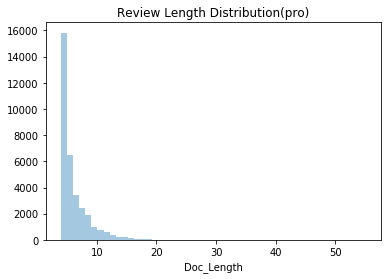

In [5]:
sns.distplot(df.Doc_Length, bins=50, kde=False)
plt.title(f'Review Length Distribution({pc_flag})')
plt.savefig(root + f'/Desktop/Paper/img/Doc_Length_distr({pc_flag}).png')

In [6]:
df.sort_values(by='Doc_Length', ascending=False).head(2)

Unnamed: 0  Ratings  Job_Status  Reviewed_Year  \
14843       14843      5.0           0           2019   
14692       14692      4.0           0           2018   

                                             Review_Text  \
14843  A great work environment, free parking garage ...   
14692  Laid back, Cafeteria onsite, flex time, great ...   

                                                Px_Texts  \
14843  accommod cafeteria conceptu develop environ er...   
14692  benefit cafeteria class employe flex growth la...   

                                              Tknz_Texts  Doc_Length  \
14843  ['accommod', 'cafeteria', 'conceptu', 'develop...          55   
14692  ['benefit', 'cafeteria', 'class', 'employe', '...          49   

       Work_Life  Benefits  Job_Advancement  Management  Culture  \
14843        3.0       5.0              2.0         5.0      5.0   
14692        4.0       4.0              3.0         2.0      4.0   

       Company_Index Company_Name  
14843             23  Phillips-66  
14692             22   Fannie-Mae

In [7]:
tot = df.shape[0]
print(df[df.Job_Status == 1].shape[0]/tot)
print(df[df.Job_Status == 0].shape[0]/tot)
display(df.shape)

0.3250951701165834
0.6749048298834166


(33624, 15)

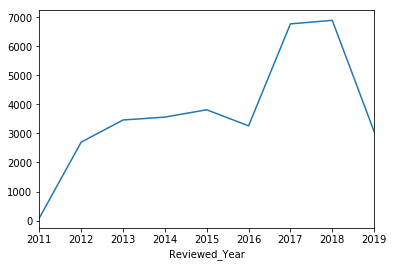

In [8]:
df.groupby('Reviewed_Year')['Reviewed_Year'].count().plot()

In [9]:
# data_px = df['Tknz_Texts'].values
data_px = df['Px_Texts'].str.split().values
data_px

array([list(['cowork', 'friendli', 'hour', 'lunch', 'friendli_cowork', 'hour_lunch', 'lunch_friendli', 'hour_lunch_friendli', 'lunch_friendli_cowork']),
       list(['benefit', 'dental', 'medic', 'myshar', 'stock']),
       list(['card', 'discount', 'schedul', 'discount_card']), ...,
       list(['benefit', 'flex', 'time', 'flex_time', 'time_benefit']),
       list(['balanc', 'benefit', 'divers', 'telecommut', 'worklif', 'benefit_divers', 'worklif_balanc']),
       list(['cowork', 'free', 'ice', 'italian', 'manag', 'thursday', 'cowork_manag', 'manag_free'])],
      dtype=object)

In [10]:
# Create Dictionary
id2word = corpora.Dictionary(data_px) ##dictionary
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]  ##corpus

# View
print(corpus[:5])

14893
Dictionary(14893 unique tokens: ['cowork', 'friendli', 'friendli_cowork', 'hour', 'hour_lunch']...)
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)], [(9, 1), (10, 1), (11, 1), (12, 1), (13, 1)], [(14, 1), (15, 1), (16, 1), (17, 1)], [(3, 1), (18, 1), (19, 1), (20, 1), (21, 1)], [(17, 1), (22, 1), (23, 1), (24, 1), (25, 1)]]


In [11]:
for i in range(14990):
    print(id2word[i])

cowork
friendli
friendli_cowork
hour
hour_lunch
hour_lunch_friendli
lunch
lunch_friendli
lunch_friendli_cowork
benefit
dental
medic
myshar
stock
card
discount
discount_card
schedul
break
length
plenti
plenti_hour
allow
job
pay
pay_schedul
friend
meet
meet_peopl
peopl
1_hr_lunch
divers
fun
hr
hr_lunch
lunch_fun
peer
set
benifit
pay_benifit
1_hour_lunch
flexibl
flexibl_schedul
hour_flexibl
discount_merchandis
employe
employe_discount
merchandis
15_minut_break
hour_lunch_paid
lunch_paid
minut
minut_break
paid
paid_15
paid_15_minut
associ
custom
custom_servic
educ
engag
excel
servic
support
flexibl_hour
hour_friendli
fast
fast_pace
pace
reward
discount_benefit
employe_discount_benefit
break_lunch
schedual
bonus
bonus_hour
bonus_hour_lunch
hour_lunch_15
lunch_15
lunch_15_minut
school
school_schedul
bonu
door
door_polici
lunch_break
mandatori
polici
share
percent
purchas
ten
abil
depart
differ
learn
learn_differ
abl
famili
visit
accid
accid_free
free
free_meal
meal
discount_food
food
lunch_h

biweekli
checkup
coffe_vend
coffe_vend_machin
free_coffe_vend
8_hour_day
enviro_paid
cater_meal
payrol
payrol_staff
cowork_support
peopl_varieti
moorestown
balanc_free
free_soda_flexibl
soda_flexibl
manag_excel
upper_manag
energ
benefit_dress
benefit_dress_code
cpar
offer_benefit
wear_jean
csometh
macromanag
invol
pto_flexibl
quarterlyholiday
advertis
bag
cent
corpor_cultur
wise
health_insur_401k
landlord
sponsor_event
nice_vacat
foodentertain
excel_cowork
excel_environ
friday_free
chair
kitchen
workstat
shoulder
healthcar_provid
builder
environ_team
calm
deliv
schedul_vacat
relax_manag
excel_health
comapni
meet_goal
lunch_breakfast
time_cowork
pto_cowork
coffe_soda
mckesson
shift_flexibl
terribl
sytem
distribut
lot_nice
lot_nice_peopl
locat_benefit
amd
differ_program
opportun_move
paid_day
complex
mainten
christma_parti
heavi
packong
throw
unschedul
common
solut
environ_freedom
together
vip
exerci
peopl_enjoy
benefit_coffe
educ_train
pay_worklif
pcp
weekli_free
soda_coffe
partnership


sap
decent_wage
save_live
albuquerqu
balloon
fiesta
lot_vacat
lot_vacat_time
violenc
option_nice
game_play
benefit_stabl
graduat
month_free
month_free_lunch
corpor_facil
lgbt
certainli
free_lunch_gift
lunch_gift
lot_free_lunch
mainli
time_healthcar
lucheon
diem
shift_hour
benefit_packag_atmospher
packag_atmospher
givaway
superl
paient
inviron
laid_atmospher
bestinclass
continuo
mngmt
weekli_paycheck
beneft
vacationpto
rid
downsid
home_day_week
plenti_time
schedulesometim
dedicada
salud
oh
amount_pto
moust
lunch_pto_benefit
manag_environ
lunch_gener
immedi_benefit
apprecait
chines
ben
balanc_employe
exersi
benefit_leadership
evnvori
free_lunch_manag
lunch_manag
appreci_day
employe_appreci_day
comradari
representatinv
fair_compens
time_start
resid
figur
summari
learn_process
method
strive
appoint
apprici
birthday_dinner
pto_health
free_free
week_easi
benefit_provid
learn_everyday
decent_peopl
pto_pay_benefit
coup
slip
standup
walki
birthday_lunch
day_employe
employe_picnic
shore
salari_p

servic_employe
cabl_health
cabl_health_care
free_cabl_health
cabl_employe
comcast_care
comcast_care_day
sorta
vac
benefit_cabl
discount_cabl_servic
perk_free_cabl
servic_benefit_commiss
bene
cabe
home_garag
cabl_internet_pay
internet_pay
cabl_servic_benefit
benefit_packag_free
benefit_discount_cabl
benefit_gift
free_servic_benefit
comcast_benefit
provid_free
sweepstak
comcast_servic_benefit
medic_dental_free
environ_perk
option_free
low_cost
pinbal
discount_cabl_tv
free_cabl_vehicl
free_servic_employe
deepli
packag_free_cabl
quarterli_bonus_benefit
peopl_free_cabl
discount_tv_internet
warrior
healthcar_discount_cabl
cableif
footprint
benefit_courtesi
benefit_courtesi_servic
servic_peopl
sevic
home_phone
home_phone_servic
internet_home_phone
obvious
phone_internet_servic
bonus_free_cabl
discliplin
servi
highli_discount
highli_discount_servic
rec
tvinternet
home_vehicl
free_tv_internet
individual
healthcar_free
healthcar_free_cabl
courtesi_servic_discount
home_van
admiss
cabl_home
free_c

deduct_health
deduct_health_benefit
health_benefit_’
low_weekli
low_weekli_deduct
plant_lot
plant_lot_overtim
sick_time_low
time_low
time_low_weekli
weekli_deduct
weekli_deduct_health
’_plant
’_plant_lot
hire_benefit
opportun_hire
opportun_hire_benefit
pay_opportun_hire
boss_plant
boss_plant_manag
lot_support_boss
plant_manag
support_boss
support_boss_plant
meal_time
meal_time_time
pay_snack
pay_snack_meal
snack_meal
snack_meal_time
time_time_union
time_union
time_union_rais
union_rais
excel_benefit_lot
lot_opportun_growth
peopl_excel_benefit
benefit_easi_learn
easi_learn_skill
learn_skill_ceil
manag_understand
manag_understand_pay
relax_manag_understand
skill_ceil
understand_pay
understand_pay_benefit
offer_pension
offer_pension_offer
pension_offer
paid_travel_decent
travel_decent
travel_decent_pay
amaz_futur
amaz_futur_ceo
ceo_connect
ceo_connect_divis
ceo_driver
ceo_driver_seat
connect_divis
connect_divis_employe
divis_employe
divis_employe_mission
driver_seat
driver_seat_ceo
employ

KeyError: 14893

In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('cowork', 1),
  ('friendli', 1),
  ('friendli_cowork', 1),
  ('hour', 1),
  ('hour_lunch', 1),
  ('hour_lunch_friendli', 1),
  ('lunch', 1),
  ('lunch_friendli', 1),
  ('lunch_friendli_cowork', 1)],
 [('benefit', 1), ('dental', 1), ('medic', 1), ('myshar', 1), ('stock', 1)],
 [('card', 1), ('discount', 1), ('discount_card', 1), ('schedul', 1)],
 [('hour', 1), ('break', 1), ('length', 1), ('plenti', 1), ('plenti_hour', 1)]]

# Set here how many topics you wanna look into 

In [14]:
# %%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
num_topics = 8
mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
%time ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, iterations=1000, random_seed=42)

CPU times: user 805 ms, sys: 21.3 ms, total: 826 ms
Wall time: 44.2 s


In [15]:
# Compute Coherence Score
%time coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 2.31 ms, sys: 1.39 ms, total: 3.7 ms
Wall time: 2.55 ms

Coherence Score:  0.3456188015276392


In [16]:
##mallet model to lda model conversion
optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [17]:
# %%time
# Visualize the topics
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis
# pyLDAvis.show(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.224659 -0.233445       1        1  12.649109
5     -0.276542 -0.077848       2        1  12.524921
0     -0.208498 -0.035564       3        1  12.518859
3      0.094973  0.163403       4        1  12.501093
6     -0.235989 -0.058489       5        1  12.464306
2      0.217101 -0.226733       6        1  12.460706
7      0.099923  0.248292       7        1  12.450563
1      0.084373  0.220383       8        1  12.430444, topic_info=     Category         Freq           Term        Total  loglift  logprob
24    Default  5389.000000            pay  5389.000000  30.0000  30.0000
9     Default  8719.000000        benefit  8719.000000  29.0000  29.0000
102   Default  4715.000000           free  4715.000000  28.0000  28.0000
29    Default  2884.000000          peopl  2884.000000  27.0000  27.0000
3     Default  2765.000000           hour  2765.000000  26.0000  26.0000
6     Default  3815.000000          lunch  3815.000000  25.0000  25.0000
110   Default  2483.000000           time  2483.000000  24.0000  24.0000
150   Default  2205.000000          manag  2205.000000  23.0000  23.0000
244   Default  2136.000000        environ  2136.000000  22.0000  22.0000
41    Default  1986.000000        flexibl  1986.000000  21.0000  21.0000
45    Default  1917.000000        employe  1917.000000  20.0000  20.0000
15    Default  1782.000000       discount  1782.000000  19.0000  19.0000
18    Default  1735.000000          break  1735.000000  18.0000  18.0000
400   Default  1688.000000       opportun  1688.000000  17.0000  17.0000
220   Default  1678.000000     free_lunch  1678.000000  16.0000  16.0000
0     Default  1512.000000         cowork  1512.000000  15.0000  15.0000
53    Default  1489.000000           paid  1489.000000  14.0000  14.0000
17    Default  1374.000000        schedul  1374.000000  13.0000  13.0000
169   Default  1375.000000         health  1375.000000  12.0000  12.0000
95    Default  1366.000000          learn  1366.000000  11.0000  11.0000
178   Default  1344.000000            lot  1344.000000  10.0000  10.0000
373   Default  1224.000000            day  1224.000000   9.0000   9.0000
301   Default  1252.000000           team  1252.000000   8.0000   8.0000
465   Default  1197.000000    pay_benefit  1197.000000   7.0000   7.0000
1     Default  1155.000000       friendli  1155.000000   6.0000   6.0000
252   Default  1138.000000           nice  1138.000000   5.0000   5.0000
496   Default  1117.000000          train  1117.000000   4.0000   4.0000
133   Default  1104.000000          vacat  1104.000000   3.0000   3.0000
128   Default  1098.000000         balanc  1098.000000   2.0000   2.0000
57    Default  1062.000000         custom  1062.000000   1.0000   1.0000
...       ...          ...            ...          ...      ...      ...
250    Topic8   395.268450           busi   395.268450   2.0850  -4.2112
158    Topic8   392.251134      co_worker   392.251134   2.0850  -4.2188
94     Topic8   390.239590         differ   390.239590   2.0850  -4.2240
67     Topic8   449.580146      fast_pace   450.595708   2.0828  -4.0824
301    Topic8  1236.093957           team  1252.342953   2.0720  -3.0710
1131   Topic8   337.939438          build   337.939438   2.0850  -4.3679
377    Topic8   334.922122          skill   334.922122   2.0850  -4.3768
97     Topic8   307.766274            abl   307.766274   2.0850  -4.4614
410    Topic8   256.471895          enjoy   256.471895   2.0850  -4.6437
537    Topic8   223.281415          activ   223.281415   2.0850  -4.7823
149    Topic8   223.281415         commun   223.281415   2.0850  -4.7823
544    Topic8   194.114023           hard   194.114023   2.0850  -4.9223
887    Topic8   189.085162           move   189.085162   2.0850  -4.9485
58     Topic8   177.015896  custom_servic   177.015896   2.0850  -5.0145
148    Topic8   156.900454         orient   156.900454   2.

In [196]:
pyLDAvis.save_html(vis, root+f'/Desktop/Paper/img/{pc_flag}/LDAviz.html')

# Here we are finding out best model

In [209]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                 iterations=1000, random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [210]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=2, limit=40, step=2)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/bishalsainju/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons/pro/Coherence_score.png'

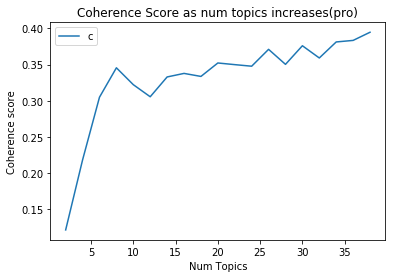

In [216]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title(f'Coherence Score as num topics increases({pc_flag})')
# plt.savefig(img_path+f'/{pc_flag}/Coherence_score.png')

In [213]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1217
Num Topics = 4  has Coherence Value of 0.2184
Num Topics = 6  has Coherence Value of 0.305
Num Topics = 8  has Coherence Value of 0.3456
Num Topics = 10  has Coherence Value of 0.3223
Num Topics = 12  has Coherence Value of 0.3056
Num Topics = 14  has Coherence Value of 0.333
Num Topics = 16  has Coherence Value of 0.3379
Num Topics = 18  has Coherence Value of 0.3337
Num Topics = 20  has Coherence Value of 0.3523
Num Topics = 22  has Coherence Value of 0.35
Num Topics = 24  has Coherence Value of 0.3478
Num Topics = 26  has Coherence Value of 0.3711
Num Topics = 28  has Coherence Value of 0.3504
Num Topics = 30  has Coherence Value of 0.3761
Num Topics = 32  has Coherence Value of 0.3592
Num Topics = 34  has Coherence Value of 0.3813
Num Topics = 36  has Coherence Value of 0.3835
Num Topics = 38  has Coherence Value of 0.3947


# Let's do some clustering to dig in deeper

In [24]:
from collections import OrderedDict
def get_doc_topic_dist(model=optimal_model, corpus=corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []
    
    for d in corpus: 
        print(d)
        print(model[d]); 

#     for d in corpus:
#         tmp = {i:0 for i in range(num_topics)}
#         tmp.update(dict(model[d]))
#         vals = list(OrderedDict(tmp).values())
#         top_dist += [np.array(vals)]
#         if kwords:
#             keys += [np.array(vals).argmax()]

#     return np.array(top_dist), keys

# top_dist, keys = get_doc_topic_dist(optimal_model, corpus, kwords=True)
# print(top_dist[:5])
# print(keys[:5])
get_doc_topic_dist()

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


TypeError: 'LdaModel' object is not callable

In [176]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

explore_topic(optimal_model, 0, 3)

hour                 0.341
shift                0.112
holiday              0.045


['hour', 'shift', 'holiday']

In [177]:
topic_summaries = []
# print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
#     print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(optimal_model,topic_number=i, topn=3, output=False )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print
    
print(topic_summaries)

# for t in topic_labels:
#     print(" ".join(t))
topic_label = [" ".join(t) for t in topic_summaries]
print(topic_label)

[['hour', 'shift', 'holiday'], ['team', 'salari', 'horribl'], ['balanc', 'life', 'life_balanc'], ['advanc', 'littl', 'opportun'], ['break', 'lunch', 'short'], ['lack', 'commun', 'manag'], ['schedul', 'hour', 'terribl'], ['pay', 'low', 'low_pay'], ['custom', 'peopl', 'employe'], ['benefit', 'care', 'health'], ['hard', 'cultur', 'move'], ['day', 'chang', 'constant'], ['lot', 'system', 'polit'], ['time', 'busi', 'compens'], ['manag', 'expect', 'week'], ['manag', 'call', 'upper'], ['manag', 'train', 'overtim'], ['poor', 'manag', 'bad'], ['stress', 'environ', 'sale'], ['employe', 'dont', 'rate'], ['due', 'secur', 'cut'], ['sometim', 'difficult', 'demand'], ['short', 'break', 'short_break'], ['time', 'posit', 'stand']]
['hour shift holiday', 'team salari horribl', 'balanc life life_balanc', 'advanc littl opportun', 'break lunch short', 'lack commun manag', 'schedul hour terribl', 'pay low low_pay', 'custom peopl employe', 'benefit care health', 'hard cultur move', 'day chang constant', 'lot 

In [178]:
top_labels = dict()

for i in range(num_topics):
    top_labels[i] = topic_label[i]
    
print(top_labels)

{0: 'hour shift holiday', 1: 'team salari horribl', 2: 'balanc life life_balanc', 3: 'advanc littl opportun', 4: 'break lunch short', 5: 'lack commun manag', 6: 'schedul hour terribl', 7: 'pay low low_pay', 8: 'custom peopl employe', 9: 'benefit care health', 10: 'hard cultur move', 11: 'day chang constant', 12: 'lot system polit', 13: 'time busi compens', 14: 'manag expect week', 15: 'manag call upper', 16: 'manag train overtim', 17: 'poor manag bad', 18: 'stress environ sale', 19: 'employe dont rate', 20: 'due secur cut', 21: 'sometim difficult demand', 22: 'short break short_break', 23: 'time posit stand'}


In [179]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(
#                             analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

# display(sentences[['Px_Texts']].values.tolist())
sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# display(sents)
# display(sentences[['Px_Texts']].values)
data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
print(data_vectorized[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [180]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = CountVectorizer()

# sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
# print(data_vectorized[:5])


In [181]:
top_dist, lda_keys= get_doc_topic_dist(optimal_model, corpus, True)
features = vectorizer.get_feature_names()
print(len(features))

16688


In [182]:
print(len(top_dist))
threshold = 0.07
# threshold = 1/num_topics
_idx = np.amax(top_dist, axis=1) > threshold  # idx of doc that above the threshold
X_topic = top_dist[_idx]
print(len(X_topic))
print(X_topic.shape)
print(X_topic)

32988
26680
(26680, 24)
[[0.03858025 0.03858025 0.03858025 ... 0.0385946  0.03858025 0.03858025]
 [0.03720238 0.03720238 0.03720238 ... 0.0372136  0.03720238 0.03720238]
 [0.05409357 0.03694959 0.03654971 ... 0.04832761 0.03654971 0.04402061]
 ...
 [0.03787879 0.03787879 0.03807476 ... 0.03789394 0.03787879 0.03787879]
 [0.03787879 0.03787879 0.03787879 ... 0.07424242 0.03787879 0.03787879]
 [0.05196241 0.0386093  0.03858025 ... 0.03858025 0.03858025 0.03858025]]


In [183]:
dtm = data_vectorized

In [184]:
p_df = pd.DataFrame()
p_df['tokenz'] = np.asarray(data_px)[_idx]
p_df.head()

tokenz
0               [clean, commun, manag, manag_commun]
1        [lack, manag, poor, staf, wage, manag_lack]
2  [associ, benefit, help, holiday, lack, pay, la...
3  [break, depart, differ, short, store, time, di...
4                       [littl, low, pay, pay_littl]

In [185]:
display(dtm)
print(p_df.shape)
print(len(X_topic))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(26680, 1)
26680


In [186]:
sentences[['Review_Text']].values

array([['Management, communication, workforce, and clean facilities.'],
       ['ovebearing managers lack of staffing poor wages'],
       ['Benefits, associate pay, and lack of help during holidays'],
       ...,
       ['management, no room for advancement, pay'],
       ['fees for being a real estate broker'],
       ['a lot of driving and long hours']], dtype=object)

In [187]:
top_ws = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]    
    top_ws += [' '.join(tmp)]


p_df['Text_Rep'] = pd.DataFrame(np.asarray(top_ws)[_idx])
p_df['clusters'] = pd.DataFrame(np.asarray(lda_keys)[_idx])
print(p_df['clusters'].isna().sum())
p_df['clusters'].fillna(num_topics, inplace=True)
p_df['Review_Text'] = pd.DataFrame(sentences[['Review_Text']].values[_idx])
# p_df['Review_Text'] = sentences['Review_Text'].ix[_idx]


colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5", 
    "#c7c7c8", "#bcbd23", "#dbdb8e", "#17beca", 
])

cluster_colors = dict()
for c in range(num_topics): 
    cluster_colors[c] = colormap[c]
    
print(cluster_colors)
# cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 
#                   7:'maroon', 8:'crimson', 9:'black', 10:'gray', 11: '#8c564b'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])





0
{0: '#1f77b4', 1: '#aec7e8', 2: '#ff7f0e', 3: '#ffbb78', 4: '#2ca02c', 5: '#98df8a', 6: '#d62728', 7: '#ff9896', 8: '#9467bd', 9: '#c5b0d5', 10: '#8c564b', 11: '#c49c94', 12: '#e377c2', 13: '#f7b6d2', 14: '#7f7f7f', 15: '#c7c7c7', 16: '#bcbd22', 17: '#dbdb8d', 18: '#17becf', 19: '#9edae5', 20: '#c7c7c8', 21: '#bcbd23', 22: '#dbdb8e', 23: '#17beca'}


In [188]:
p_df.shape

(26680, 5)

In [189]:
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

X_tsne = tsne.fit_transform(X_topic)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 26680 samples in 0.139s...
[t-SNE] Computed neighbors for 26680 samples in 27.845s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26680
[t-SNE] Computed conditional probabilities for sample 2000 / 26680
[t-SNE] Computed conditional probabilities for sample 3000 / 26680
[t-SNE] Computed conditional probabilities for sample 4000 / 26680
[t-SNE] Computed conditional probabilities for sample 5000 / 26680
[t-SNE] Computed conditional probabilities for sample 6000 / 26680
[t-SNE] Computed conditional probabilities for sample 7000 / 26680
[t-SNE] Computed conditional probabilities for sample 8000 / 26680
[t-SNE] Computed conditional probabilities for sample 9000 / 26680
[t-SNE] Computed conditional probabilities for sample 10000 / 26680
[t-SNE] Computed conditional probabilities for sample 11000 / 26680
[t-SNE] Computed conditional probabilities for sample 12000 / 26680
[t-SNE] Computed conditional probabilities for sa

In [190]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]
len(X_tsne[:, 0])

26680

In [191]:
display(p_df.head())
# print(p_df.shape)
print(p_df.iloc[4]['Review_Text'])

tokenz  \
0               [clean, commun, manag, manag_commun]   
1        [lack, manag, poor, staf, wage, manag_lack]   
2  [associ, benefit, help, holiday, lack, pay, la...   
3  [break, depart, differ, short, store, time, di...   
4                       [littl, low, pay, pay_littl]   

                            Text_Rep  clusters  \
0    clean manag_commun commun manag         5   
1          manag_lack staf wage lack         5   
2     lack_help pay_lack associ help         7   
3  differ_depart differ store depart        21   
4            pay_littl littl low pay         7   

                                         Review_Text   colors     X_tsne  \
0  Management, communication, workforce, and clea...  #98df8a -17.230560   
1    ovebearing managers lack of staffing poor wages  #98df8a -17.790483   
2  Benefits, associate pay, and lack of help duri...  #ff9896 -13.729136   
3  Short breaks, and get stationed in different d...  #bcbd23  31.095310   
4                              the pays a little low  #ff9896  -4.332639   

      Y_tsne  
0  22.655071  
1  25.002192  
2  25.563028  
3   8.111913  
4  52.944889

the pays a little low


In [192]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [193]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= p_df['clusters'],
    content = p_df['tokenz'],
    review_text = p_df['Review_Text']
))

In [197]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "KeyWords: @content <br> ReviewText: @review_text <br> Topic: @label "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons'
save(plot_lda, root+'/Desktop/Paper/img/con/24/cluster.html')

/anaconda3/lib/python3.7/site-packages/bokeh/io/saving.py:126: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/anaconda3/lib/python3.7/site-packages/bokeh/io/saving.py:139: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


'/Users/bishalsainju/Desktop/Paper/img/con/24/cluster.html'